# Ensemble : Bagging

## 1.환경준비

### (1) import

In [7]:
#라이브러리들을 불러오자.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 전처리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 모델링
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import * 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import warnings    # 경고메시지 제외
warnings.filterwarnings(action='ignore')

### (2) 데이터 준비

* 변수설명
    * COLLEGE : 대학 졸업여부
    * INCOME : 연수입
    * OVERAGE : 월평균 초과사용 시간(분)
    * LEFTOVER : 월평균 잔여시간비율(%)
    * HOUSE : 집값
    * HANDSET_PRICE : 스마트폰 가격
    * OVER_15MINS_CALLS_PER_MONTH : 월평균 장기통화(15분이상) 횟수
    * AVERAGE_CALL_DURATION : 평균 통화 시간
    * REPORTED_SATISFACTION : 만족도 설문조사 결과
    * REPORTED_USAGE_LEVEL : 사용도 자가진단 결과
    * CONSIDERING_CHANGE_OF_PLAN : 향후 변경계획 설문조사 결과
    * CHURN : 이탈(번호이동) 여부 (1-이탈, 0-잔류, Target 변수)


In [8]:
# 데이터를 불러옵시다.
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/mobile_cust_churn.csv'
data = pd.read_csv(path)
data = data.sample(5000, random_state = 2022)
data['CHURN'] = data['CHURN'].map({'LEAVE':1, 'STAY':0})
data.head()
display(data.shape)

(5000, 13)

## 2.데이터 준비

### (1) 데이터 정리

In [9]:
drop_cols = ['id']
data.drop(drop_cols, axis = 1, inplace = True )

### (2) 데이터분할1 : x, y 나누기

In [10]:
target = 'CHURN'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

### (3) NA 조치

### (4) 가변수화

In [11]:
dumm_cols = ['REPORTED_SATISFACTION','REPORTED_USAGE_LEVEL','CONSIDERING_CHANGE_OF_PLAN']
x = pd.get_dummies(x, columns = dumm_cols, drop_first = True)

### (5) 데이터분할2 : train : validation

In [12]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.3, random_state = 2022)

## 3.모델링 : 랜덤포레스트


In [13]:
# 모델 선언
model = RandomForestClassifier(n_estimators = 5, max_depth = 3)

In [14]:
# 학습
model.fit(x_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=5)

In [15]:
# 예측
pred = model.predict(x_val)

In [16]:
# 평가
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.68      0.79      0.73       769
           1       0.73      0.61      0.66       731

    accuracy                           0.70      1500
   macro avg       0.70      0.70      0.70      1500
weighted avg       0.70      0.70      0.70      1500



## 4.시각화와 변수중요도

### (1) 모델의 내부를 살펴봅시다.

In [13]:
# 5개 decision tree
model.estimators_[4]

DecisionTreeClassifier(max_depth=3, max_features='auto', random_state=677652613)

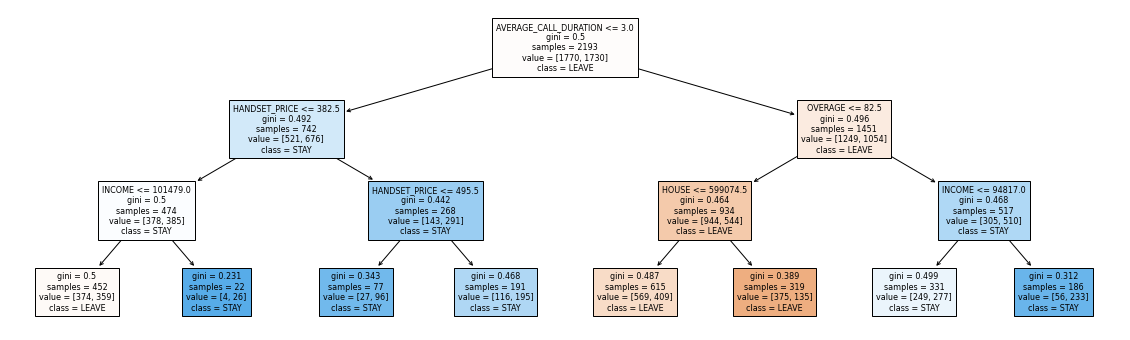

In [16]:
# 각 트리별로 시각화 할 수 있다.
plt.figure(figsize=(20,6))
plot_tree(model.estimators_[2], 
               feature_names = x_train.columns,
               class_names= ['LEAVE','STAY'], 
               filled = True, fontsize = 8);

### (2) 변수 중요도

In [17]:
# 변수 중요도
print(x_train.columns)
print(model.feature_importances_)

Index(['COLLEGE', 'INCOME', 'OVERAGE', 'LEFTOVER', 'HOUSE', 'HANDSET_PRICE',
       'OVER_15MINS_CALLS_PER_MONTH', 'AVERAGE_CALL_DURATION',
       'REPORTED_SATISFACTION_sat', 'REPORTED_SATISFACTION_unsat',
       'REPORTED_SATISFACTION_very_sat', 'REPORTED_SATISFACTION_very_unsat',
       'REPORTED_USAGE_LEVEL_high', 'REPORTED_USAGE_LEVEL_little',
       'REPORTED_USAGE_LEVEL_very_high', 'REPORTED_USAGE_LEVEL_very_little',
       'CONSIDERING_CHANGE_OF_PLAN_considering',
       'CONSIDERING_CHANGE_OF_PLAN_never_thought',
       'CONSIDERING_CHANGE_OF_PLAN_no', 'CONSIDERING_CHANGE_OF_PLAN_perhaps'],
      dtype='object')
[5.63369919e-03 1.70670512e-01 1.03731179e-01 5.70519680e-02
 4.48823956e-01 5.65053248e-02 1.16821293e-01 2.40166126e-02
 2.29040274e-03 0.00000000e+00 4.71462324e-03 0.00000000e+00
 7.88549283e-03 0.00000000e+00 1.59047845e-04 1.69588925e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]


* 변수중요도 그래프 그리기 함수 만들기

In [18]:
def plot_feature_importance(importance, names):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df.reset_index(drop=True, inplace = True)

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.grid()

    return fi_df

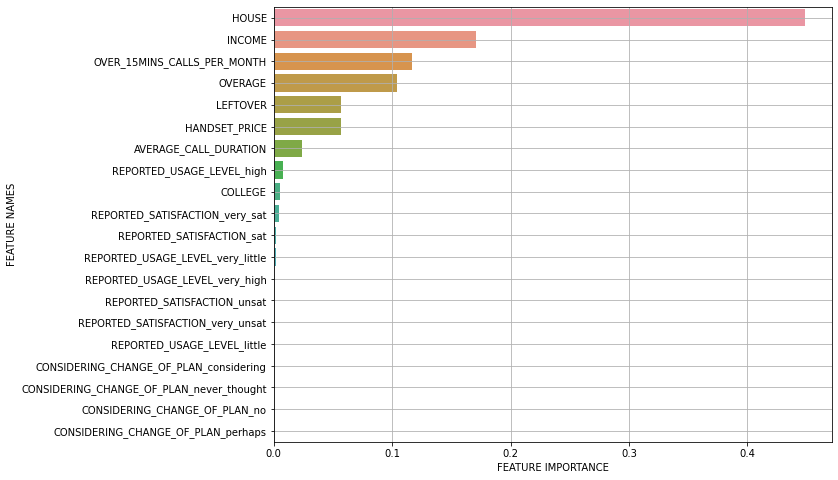

In [19]:
result = plot_feature_importance(model.feature_importances_, x_train.columns)

In [20]:
result

,feature_names,feature_importance
0,HOUSE,0.448824
1,INCOME,0.170671
2,OVER_15MINS_CALLS_PER_MONTH,0.116821
3,OVERAGE,0.103731
4,LEFTOVER,0.057052
5,HANDSET_PRICE,0.056505
6,AVERAGE_CALL_DURATION,0.024017
7,REPORTED_USAGE_LEVEL_high,0.007885
8,COLLEGE,0.005634
9,REPORTED_SATISFACTION_very_sat,0.004715


## 5.실습: random forest 튜닝

* grid search를 수행합니다.
    * ① n_estimators 의 갯수를 5 ~ 200까지 5개씩 증가시켜가며 튜닝해 봅시다.
    * ② max_features를 1 ~ feature갯수까지 1씩 증가시켜가며 튜닝해 봅시다.
    * ③ n_estimators, max_features를 동시에 튜닝.

* 모델링 후 cv 평가 결과를 차트로 그려봅시다. 
* 튜닝된 모델로 부터 변수중요도를 뽑아 봅시다.


### (1) n_estimators 튜닝

In [24]:
params = {'n_estimators':range(5,201,5)}

In [27]:
m = RandomForestClassifier()
m_gs1 = GridSearchCV(m, params, cv = 5, verbose = 3)

In [28]:
m_gs1.fit(x_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END ....................n_estimators=5;, score=0.619 total time=   0.0s
[CV 2/5] END ....................n_estimators=5;, score=0.649 total time=   0.0s
[CV 3/5] END ....................n_estimators=5;, score=0.651 total time=   0.0s
[CV 4/5] END ....................n_estimators=5;, score=0.621 total time=   0.0s
[CV 5/5] END ....................n_estimators=5;, score=0.654 total time=   0.0s
[CV 1/5] END ...................n_estimators=10;, score=0.611 total time=   0.0s
[CV 2/5] END ...................n_estimators=10;, score=0.667 total time=   0.0s
[CV 3/5] END ...................n_estimators=10;, score=0.641 total time=   0.0s
[CV 4/5] END ...................n_estimators=10;, score=0.637 total time=   0.0s
[CV 5/5] END ...................n_estimators=10;, score=0.664 total time=   0.0s
[CV 1/5] END ...................n_estimators=15;, score=0.656 total time=   0.0s
[CV 2/5] END ...................n_estimators=15

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': range(5, 201, 5)}, verbose=3)

In [30]:
m_gs1.best_params_, m_gs1.best_score_

({'n_estimators': 65}, 0.6897142857142857)

In [32]:
p1 = m_gs1.predict(x_val)
print(classification_report(y_val, p1))

              precision    recall  f1-score   support

           0       0.71      0.70      0.70       769
           1       0.69      0.69      0.69       731

    accuracy                           0.70      1500
   macro avg       0.70      0.70      0.70      1500
weighted avg       0.70      0.70      0.70      1500



* 튜닝 결과를 그래프로 그려보겠습니다.

In [36]:
# 튜닝 결과를 데이터프레임으로 저장
result = pd.DataFrame(m_gs1.cv_results_)
temp = result.loc[:, ['param_n_estimators', 'mean_test_score']]
temp.head()

,param_n_estimators,mean_test_score
0,5,0.638857
1,10,0.644286
2,15,0.669714
3,20,0.672000
4,25,0.660571


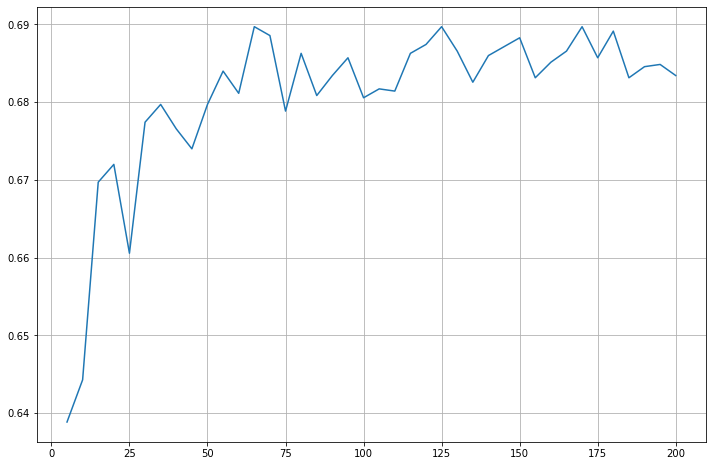

In [37]:
plt.figure(figsize = (12,8))
plt.plot('param_n_estimators', 'mean_test_score', data = temp)
plt.grid()
plt.show()

### (2) max_features 튜닝

* 변수 중요도

### (3) n_estimators와 max_features를 한꺼번에 튜닝